# BigDFT for solid state systems

In this notebook, a simple example of a solid state calculation is given by considering two-dimensional (2D) materials. In order to demonstrate the robustness and the flexibility of BigDFT, two case studies of graphene are presented, i.e. with cubic and linear scaling.  
Each calculation is initialized with the proper boundary conditions as the code natively handles dimensionality. The density of states (DoS) and the band structure are then computed within the cubic scaling approach, while the former is compared to the DoS obtained by linear scaling calculation

In [27]:
import numpy as np
sq3 = np.sqrt(3)

## Graphene

[Graphene](https://en.wikipedia.org/wiki/Graphene) is a 2D carbon allotrope in the form of a honeycomb network that consists of a two inequivalent triangular lattices, with a C-C bond of 1.42$~$angstroem, or equivalently, a lattice parameter such that $a_0 = 2.46~$angstroem.

In BigDFT, the $y$-axis is set to infinity to simulate a 2D materials (or slabs) while orthorombic cells are employed to model hexagonal lattices. Note that the yaml input format requires `float` when using numpy data types.

In [28]:
from BigDFT.UnitCells import UnitCell

a0 = 2.5 # A
cell = UnitCell([float(a0*sq3),float(np.inf),a0], units='angstroem')

The position of the atoms are then specified in fractional coordinates, while reduced coordinates should be preferably employed when using fully periodic boundary conditions.

In [29]:
from BigDFT.Atoms import Atom

at1 = Atom({'r':[0.000000,0.0,a0/2], 'sym':'C', 'units':'angstroem'})
at2 = Atom({'r':[a0/2/sq3,0.0,0.00], 'sym':'C', 'units':'angstroem'})
at3 = Atom({'r':[a0*sq3/2,0.0,0.00], 'sym':'C', 'units':'angstroem'})
at4 = Atom({'r':[a0*2/sq3,0.0,a0/2], 'sym':'C', 'units':'angstroem'})

The system is then constructed from the cell and the atomic coordinates, where we divide the two sublattices into a fragment each.

In [30]:
from BigDFT.Systems import System
from BigDFT.Fragments import Fragment

graphene = System()
graphene.cell = cell
graphene['C:0'] = Fragment([at1,at3])
graphene['C:1'] = Fragment([at2,at4])

For clarity, the atomic positions are printed and displayed.

In [31]:
[print(i) for i in graphene.get_posinp()['positions']];

{'C': [0.0, 0.0, 1.25], 'frag': ['C', '0']}
{'C': [2.1650635094610964, 0.0, 0.0], 'frag': ['C', '0']}
{'C': [0.7216878364870323, 0.0, 0.0], 'frag': ['C', '1']}
{'C': [2.886751345948129, 0.0, 1.25], 'frag': ['C', '1']}


In [32]:
graphene.display();

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

In order to properly characterize extended systems in BigDFT, a finer grid spacing is needed for wavelet calculations while a $k$-points mesh is provided to handle periodicity. 

In [33]:
from BigDFT import Inputfiles as I

inp_gr = I.Inputfile()
inp_gr.set_hgrid(0.3)
inp_gr['kpt'] = {'method':'mpgrid', 'ngkpt':[15,1,27]}

Additionally, mixing is required for the calculation to converge, such that the effect of abrupt changes in the density are smoothened away.

In [34]:
inp_gr['import'] = 'mixing'
inp_gr['mix'] = {'norbsempty':10, 'rpnrm_cv':1e-10}

Note that `norbsempty` has been reduced from its default value as only a few bands are relevant above the Fermi level. Similarly, a softer convergence criterion is defined. 

Now that both the system geometry and the input files were defined, a calculator is instantiated using OpenMP and MPI parallelisation.

In [35]:
from BigDFT import Calculators as C

calc = C.SystemCalculator(verbose=False,omp=1,mpi_run='mpirun -np 1')
log_gr = calc.run(input=inp_gr,posinp=graphene.get_posinp(),name='graphene',dry_run=True)

 <BigDFT> log of the run will be written in logfile: ./log-graphene.yaml
 <BigDFT> Logfile existing, renamed into: ./logfiles/log-graphene.16:22:06.851.yaml


Once the calculation is successfully performed, a log file has been produced. Here, we provide the corresponding log file, owing to the significant computational requirement of the current calculation for a regular workstation. Alternatively, one may run the calculation on a remote cluster using the `RemoteRunner` class (see this [tutorial](./RemoteRunner.ipynb)).

In [36]:
from BigDFT import Logfiles

log_gr = Logfiles.Logfile('log-graphene_kpt.yaml')

It is sensible to inspect atomic forces once the calculation is done, to ensure the reliability of the system modeling. A typical value for a converged calculation should be below $10^{-3}~$ Ha/bohr.

In [37]:
log_gr.log['Atomic Forces (Ha/Bohr)']

[{'C': [3.725158813391e-05, 0.0, -1.280528231035e-18]},
 {'C': [3.725158813391e-05, 0.0, 2.817162108277e-18]},
 {'C': [-3.725158813391e-05, 0.0, -2.048845169656e-18]},
 {'C': [-3.725158813391e-05, 0.0, -2.048845169656e-18]}]

Note that the `log` attribute enables to convert the `Logfile` into a dictionary.

## The electronic properties of graphene

Let us now analyze the electronic properties of graphene. Our first task will concern the computation of the Density of States (DoS).

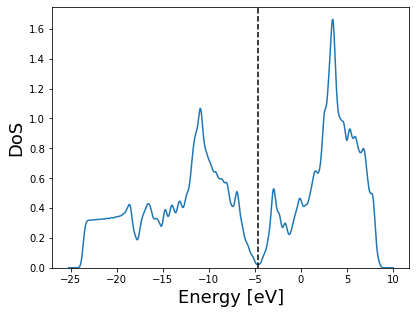

In [38]:
DoS = log_gr.get_dos() #the density of states
ax = DoS.plot()
ax.set_ylim([0,None]);

When analysing electronic properties, the $k$-dependence is obtained by plotting the band structure. This is done along a given path, that can be specified by the user. 

In [39]:
BZ_gr = log_gr.get_brillouin_zone()

hsp = BZ_gr.special_points # high symmetry points
[print(i) for i in hsp.items()]
paths = BZ_gr.special_paths # high symmetry path list
print(paths)

spacegroup P6/mmm (191)
Lattice found: orthorhombic
irreductible k-points 112


/home/sam/Software/miniconda/miniconda3/lib/python3.9/site-packages/ase/dft/kpoints.py:655: UserWarning: Please call this function with cell as the first argument
  warnings.warn('Please call this function with cell as the first '


Interpolation bias 1.0852849288836878e-08
('G', array([0., 0., 0.]))
('R', array([0.5, 0.5, 0.5]))
('S', array([0. , 0.5, 0.5]))
('T', array([0.5, 0. , 0.5]))
('U', array([0.5, 0.5, 0. ]))
('X', array([0. , 0.5, 0. ]))
('Y', array([0. , 0. , 0.5]))
('Z', array([0.5, 0. , 0. ]))
[['G', 'X', 'S', 'Y', 'G', 'Z', 'U', 'R', 'T', 'Z'], ['Y', 'T'], ['U', 'X'], ['S', 'R']]


Here we choose half the first path, since the 2D character of our system implies no dependence in $k_x$.

In [40]:
print(paths[0][:5])

['G', 'X', 'S', 'Y', 'G']


Alternatively, one could also define its own path such that $k_x=0$.

In [41]:
path = []
for p in paths[0]:
    if hsp[p][0]==0.0: path.append(p)
print(path)

['G', 'X', 'S', 'Y', 'G']


Eventually, the band structure is plotted using the `BZ` class by giving a list of special $k$-points (i.e. the `path` defined above)

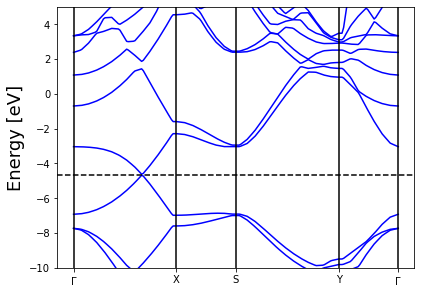

In [42]:
import BigDFT.BZ as BZ

npts = 200
path_bs = BZ.BZPath(BZ_gr.lattice,path,hsp,npts=npts)

ax = BZ_gr.plot(path=path_bs,npts=npts)
ax.set_ylim([-10,5]);

## Linear scaling in graphene

Now that we have seen how to describe graphene using first-principles simulations, let us apply the linear scaling framework to it. 
More information on the implementation of linear scaling in BigDFT is accessible [here](https://pubs.rsc.org/en/content/articlelanding/2015/cp/c5cp00437c/unauth)

For that matter, one needs first to define a cell large enough so that electronic properties are well described at the $\Gamma$ point.

In [43]:
def sys_extend(sys,n1,n2):
    
    from copy import deepcopy
    sys_ext = deepcopy(sys)
    pos = sys.get_posinp()['positions'];
    vec = sys.cell.get_posinp(units='bohr')
    
    for i1 in range(n1):
        for i2 in range(n2):
            if i1==0 and i2==0:
                continue
            v_i = [i1*vec[0],0,i2*vec[2]]
            for frag in list(sys):
                tmp = deepcopy(sys[frag])
                tmp.translate(v_i)
                for at in tmp:
                    sys_ext[frag].append(at)
    sys_ext.cell = UnitCell([n1*vec[0],float(np.inf),n2*vec[2]], units='bohr')
    
    return sys_ext

If one desires to vizualize the supercell, it is advised that $n_x$ and $n_y$ remain small. 

In [44]:
gr_scell = sys_extend(graphene,5,5)
gr_scell.display();

You appear to be running in JupyterLab (or JavaScript failed to load for some other reason). You need to install the 3dmol extension: 
 jupyter labextension install jupyterlab_3dmol

Since a $\{k_y,k_z\}=\{15,27\}$ grid was used in reciprocal space, the linear calculation requires a significant supercell to compute the spatially resolved DoS.

In [45]:
gr_scell = sys_extend(graphene,11,19)

The linear scaling input file is then written down simply by doing

In [46]:
from BigDFT import Inputfiles as I

inp_scell = I.Inputfile()
inp_scell['import'] = 'linear'

The spatially resolved DoS is computed when

In [47]:
inp_scell['lin_general'] = {'subspace_diag': 'Yes'}

In order to run `bigdft` on the input file `gr_scell.yaml`, sizeable computational ressources are required. For that matter, one may use a `RemoteRunner` (see this [tutorial](./RemoteRunner.ipynb)) to perform the computation on a cluster. 

For convenience, the resulting logile is provided.

In [48]:
# log_scell = calc.run(input=inp_scell,posinp=gr_scell.get_posinp(),name='gr_scell',dry_run=True)
log_scell = Logfiles.Logfile('log-gr_scell.yaml')

Finally, the DoS is plotted using our path defined previously.

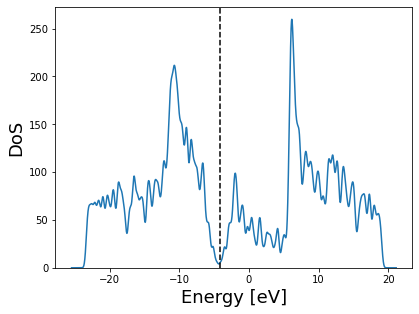

In [49]:
DoS = log_scell.get_dos() #the density of states
ax = DoS.plot()
ax.set_ylim([0,None]);

As one can see, the DoS obtained by linear and cubic scaling are quite comparable. 